# Задание 2.0: Exploration (Модель + Спрос) для одного товара

In [1]:
from IPython.display import Image, Math
import pandas as pd
import numpy as np
from tqdm import tqdm
from typing import Dict, List, Tuple, Any, Union
from scipy import stats
import random

# Для симуляции среды
from scipy.optimize import fsolve

# Для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

color = sns.color_palette()
%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

# Для логгирования
import logging

logging.basicConfig()
logger = logging.getLogger("model")
logger.setLevel(logging.INFO)

In [2]:
class Strategy:
    def __init__(self, n_arms: int):
        """
        Инициализация базовой стратегии.

        Параметры:
        - n_arms (int): Количество доступных ручек (опций) для выбора.

        Атрибуты:
        - n_arms (int): Хранит количество ручек.
        - n_iters (int): Счетчик количества сделанных выборов (итераций).
        - arms_states (dict): Словарь, хранящий массивы с суммарными значениями различных метрик (например,
                              количество, выручка, маржа), полученными от каждой ручки.
        - arms_actions (np.array): Массив, хранящий количество выборов каждой ручки.
        """
        self.n_arms = n_arms
        self.n_iters = 0
        self.arms_states = {
            "quantity": np.zeros(n_arms),
            "revenue": np.zeros(n_arms),
            "margin": np.zeros(n_arms),
        }
        self.arms_actions = np.zeros(n_arms)  # Количество действий для каждой ручки

    def flush(self):
        """
        Сброс состояния стратегии.

        Обнуляет счетчик итераций и массивы состояний и действий ручек,
        что позволяет начать процесс выбора заново без потери информации о количестве ручек.
        """
        self.n_iters = 0
        for metric in self.arms_states.keys():
            self.arms_states[metric] = np.zeros(self.n_arms)
        self.arms_actions = np.zeros(self.n_arms)

    def update_reward(self, arm_id: int, metrics: Dict[str, float]):
        """
        Обновляет информацию о метриках и выборах для указанной ручки.

        Параметры:
        - arm_id (int): Индекс ручки, для которой обновляется информация.
        - metrics (Dict[str, float]): Словарь с метриками (например, количество, выручка, маржа),
                                      полученными за выбор данной ручки.

        При вызове увеличивает количество итераций, обновляет суммарные значения указанных метрик
        и учет количества выборов для указанной ручки.
        """
        self.n_iters += 1
        for metric, value in metrics.items():
            self.arms_states[metric][arm_id] += value
        self.arms_actions[arm_id] += 1  # Увеличиваем счетчик действий для ручки

    def choose_arm(self):
        """
        Абстрактный метод выбора ручки.

        Должен быть реализован в подклассах, определяя специфическую логику выбора ручки.

        Выбрасывает исключение, если вызывается напрямую, т.к. требует реализации в подклассе.
        """
        raise NotImplementedError("This method should be implemented by subclasses")

In [3]:
class EpsGreedy(Strategy):
    def __init__(self, n_arms: int, eps: float = 0.1):
        """
        Инициализация ε-жадной стратегии.

        Параметры:
        - n_arms (int): Количество доступных опций для выбора.
        - eps (float): Вероятность исследования, где 0 <= eps <= 1. С вероятностью eps
                       алгоритм выбирает случайную опцию, а с вероятностью 1 - eps — опцию
                       с максимальным средним вознаграждением.
        """
        super().__init__(n_arms)
        self.eps = eps

    def choose_arm(self, target: str) -> int:
        """
        Выбор опции с учетом стратегии ε-жадности.

        С вероятностью eps происходит случайный выбор опции. В противном случае выбирается
        опция с максимальным средним вознаграждением.

        Возвращает:
        - int: Индекс выбранной опции.
        """
        # Случайный выбор с вероятностью eps
        if random.random() < self.eps:
            return random.randint(0, self.n_arms - 1)
        else:
            # Вычисление средних вознаграждений для каждой опции
            arm_rewards = self.arms_states[target] / (
                self.arms_actions + 1e-5
            )  # Предотвращение деления на ноль
            # Выбор опции с максимальным средним вознаграждением
            return np.argmax(arm_rewards)

In [4]:
class PriceEnv:
    def __init__(
        self, prices: List[float], cost: float, base_demand: float, elasticity: float
    ):
        """
        Инициализация среды с заданным набором цен и параметрами для моделирования спроса.
        - prices (list): Список цен.
        - base_demand (float): Максимально возможный спрос при нулевой цене.
        - elasticity (float): Коэффициент, влияющий на чувствительность спроса к изменению цены.
        """
        self.prices = prices
        self.cost = cost
        self.base_demand = base_demand
        self.elasticity = elasticity

    @property
    def n_arms(self) -> int:
        """
        Возвращает количество доступных цен.
        - int: Количество опций.
        """
        return len(self.prices)

    def pull_arm(self, arm_id: int) -> float:
        """
        Возвращает вознаграждение за выбор определенной опции, основываясь на её цене.
        - arm_id (int): Индекс выбранной опции.
        """
        price = self.prices[arm_id]
        return self.get_reward(price=price)

    def quantity_curve(
        self, price: Union[np.ndarray, float]
    ) -> Union[np.ndarray, float]:
        """
        Вычисляет спрос на основе заданной цены, используя логистическую функцию спроса.
        - price (np.ndarray | float): Цена или массив цен.
        """
        return self.base_demand / (1 + np.exp(self.elasticity * price))

    def get_reward(
        self, price: Union[np.ndarray, float]
    ) -> Dict[str, Union[np.ndarray, float]]:
        """
        Рассчитывает количественные показатели на основе цены: количество, выручку и маржу.
        - price (np.ndarray | float): Цена или массив цен.
        """
        quantity = self.quantity_curve(price)
        # Предполагаем, что фактическое количество продаж может варьироваться вокруг ожидаемого значения
        # Для этого используем распределение Пуассона
        quantity = np.random.poisson(quantity)
        revenue = price * quantity
        margin = revenue - self.cost * quantity
        return {"quantity": quantity, "revenue": revenue, "margin": margin}

    def derivative(
        self, price: Union[np.ndarray, float], target: str
    ) -> Union[np.ndarray, float]:
        """
        Вычисляет производную целевого показателя по цене.
        - price (np.ndarray | float): Цена или массив цен.
        - target (str): Целевой показатель ('revenue', 'margin', 'quantity').
        """
        quantity_derivative = (
            -self.base_demand
            * self.elasticity
            * np.exp(self.elasticity * price)
            / ((np.exp(self.elasticity * price) + 1) ** 2)
        )
        if target == "revenue":
            return quantity_derivative * price + self.quantity_curve(price)
        elif target == "margin":
            return quantity_derivative * (price - self.cost) + self.quantity_curve(
                price
            )
        elif target == "quantity":
            return quantity_derivative
        else:
            raise ValueError("Unsupported target for derivative calculation")

    def get_optimal_price(self, target: str) -> Union[np.ndarray, float]:
        """
        Использует производную функции целевого показателя для нахождения оптимальной цены.
        - target (str): Целевой показатель для оптимизации ('revenue', 'margin', 'quantity').
        Для того чтобы найти максимум функции, необходимо найти точку, в которой её производная равна нулю.
        """
        return fsolve(self.derivative, 0, args=(target))[0]

In [5]:
class Bandit:
    def __init__(self, env: PriceEnv, strategy: Strategy, target: str):
        """
        Инициализация экземпляра многорукого бандита.

        Параметры:
        - env (PriceEnv): Среда, содержащая информацию о ценах и спросе.
        - strategy (Strategy): Стратегия выбора ручки (опции).
        """
        self.env = env
        self.strategy = strategy
        self.target = target
        self.n_iters = 0
        self.cum_regret = 0
        self.cum_reward = 0
        self.optimal_price = env.get_optimal_price(target=target)
        self.optimal_reward = env.get_reward(price=self.optimal_price)[target]

    def action(self) -> None:
        """

        Выполнение одного действия выбора и обновления статистики.
        """
        arm_id = self.strategy.choose_arm(target=self.target)
        metrics = self.env.pull_arm(arm_id=arm_id)
        self.strategy.update_reward(arm_id=arm_id, metrics=metrics)
        self.n_iters += 1
        reward = metrics[self.target]
        # Рассчитываем и обновляем кумулятивную награду
        self.cum_reward += reward
        # Рассчитываем и обновляем кумулятивное сожаление
        self.cum_regret += self.optimal_reward - reward

    def plot_curves(self, step: int) -> None:
        mean_quantity = (
            self.strategy.arms_states["quantity"] / self.strategy.arms_actions
        )
        mean_revenue = self.strategy.arms_states["revenue"] / self.strategy.arms_actions
        mean_margin = self.strategy.arms_states["margin"] / self.strategy.arms_actions

        plt.figure(figsize=(20, 4))

        metric_dict = {
            "Средний Quantity": {
                "color": "blue",
                "id": 1,
                "values": mean_quantity,
            },
            "Средний Revenue": {
                "color": "green",
                "id": 2,
                "values": mean_revenue,
            },
            "Средний Margin": {
                "color": "black",
                "id": 3,
                "values": mean_margin,
            },
        }
        for metric_name, plot_dict in metric_dict.items():
            ax1 = plt.subplot(1, len(metric_dict.keys()), plot_dict["id"])
            ax1.plot(
                self.env.prices,
                plot_dict["values"],
                marker="o",
                linestyle="-",
                color=plot_dict["color"],
                label=metric_name,
            )
            ax1.axvline(
                x=self.optimal_price,
                color="orange",
                linestyle="--",
                label=f"Оптимальная цена: {self.optimal_price:.2f}",
            )
            ax1.set_title(f"{metric_name} и действия по ценам на шаге {step}")
            ax1.set_xlabel("Цена")
            ax1.set_ylabel(metric_name)
            ax1.grid(True)

            # Добавляем столбики для arms_actions
            ax2 = ax1.twinx()
            ax2.bar(
                self.env.prices,
                self.strategy.arms_actions,
                color="grey",
                alpha=0.5,
                width=3,
                label="Количество действий",
            )
            ax2.set_ylabel("Количество действий")

            ax1.legend(loc="center right")
            ax2.legend(loc="upper right")

        plt.tight_layout()
        plt.show()

    def run_simulation(
        self,
        n_steps: int,
        do_plot_curves: bool = False,
        do_stop_exploration: bool = False,
        min_actions_num: int = 100,
        plot_step: int = 100,
    ) -> Tuple[float, float]:
        """
        Запускает симуляцию выбора на заданное количество шагов.

        Параметры:
        - n_steps (int): Количество шагов симуляции.

        Возвращает:
        - tuple: Два массива numpy - кумулятивное сожаление и кумулятивная награда за каждый шаг.
        """
        cum_regrets = np.zeros(n_steps)
        cum_rewards = np.zeros(n_steps)

        for step in range(n_steps):
            action_output = self.action()

            cum_regrets[step] = self.cum_regret
            cum_rewards[step] = self.cum_reward

            if do_plot_curves and (step % plot_step == 0 or step == n_steps - 1):
                self.plot_curves(step=step)

            if (
                do_stop_exploration
                and (self.strategy.arms_actions > min_actions_num).all()
            ):
                logger.info(
                    f"Early stopping at {step} step because the number of actions for each arm is greater than min_actions_num = {min_actions_num}"
                )
                self.plot_curves(step=step)
                break

        mean_quantity = (
            self.strategy.arms_states["quantity"] / self.strategy.arms_actions
        )
        mean_revenue = self.strategy.arms_states["revenue"] / self.strategy.arms_actions
        mean_margin = self.strategy.arms_states["margin"] / self.strategy.arms_actions
        return {
            "cum_regrets": cum_regrets,
            "cum_rewards": cum_rewards,
            "mean_quantity": mean_quantity,
            "mean_revenue": mean_revenue,
            "mean_margin": mean_margin,
        }

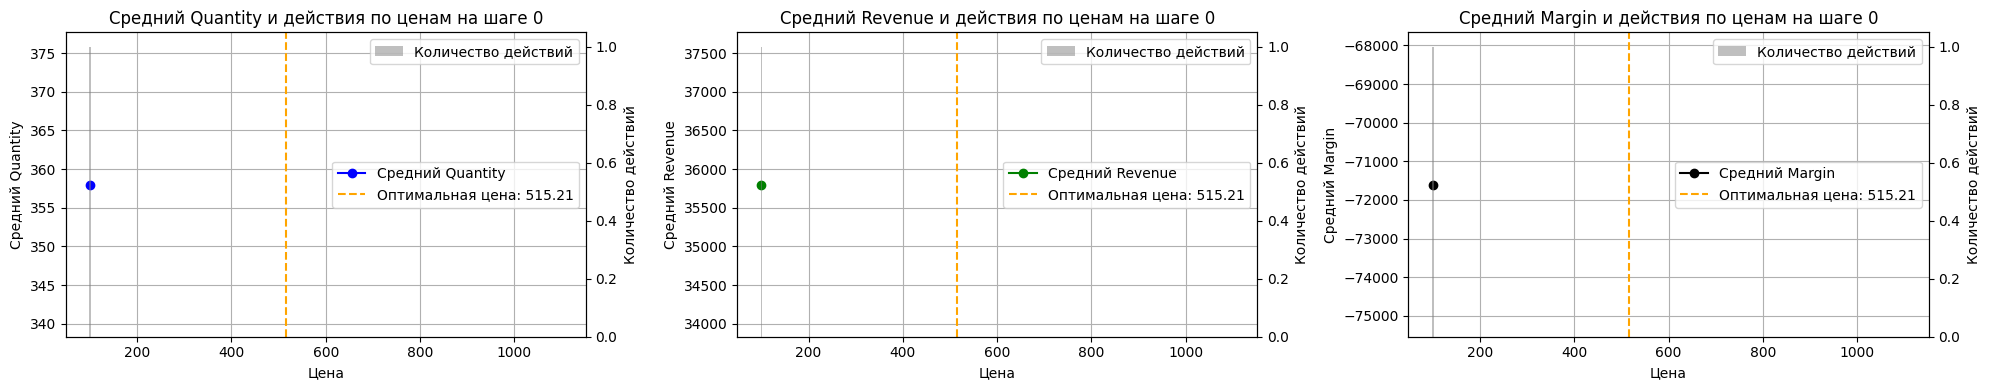

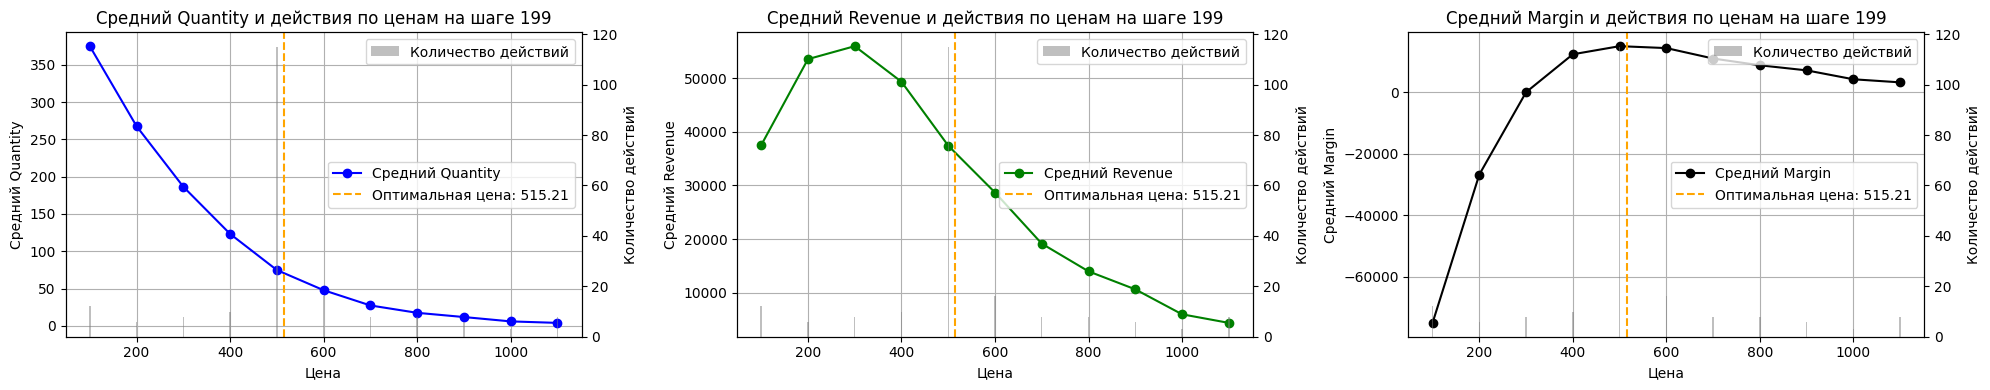

,mean_revenue,mean_margin,price
0,37500.000000,-75000.000000,100
1,53533.333333,-26766.666667,200
2,55950.000000,0.000000,300
3,49320.000000,12330.000000,400
4,37417.391304,14966.956522,500


In [6]:
np.random.seed(54)
random.seed(54)

elasticity = 0.005
cost = 300
base_demand = 1000
prices = np.arange(100, 1200, 100).round(2).tolist()
n_steps = 200
target = "margin"
env = PriceEnv(prices=prices, cost=cost, base_demand=base_demand, elasticity=elasticity)
strategy = EpsGreedy(n_arms=env.n_arms, eps=0.4)
bandit = Bandit(env=env, strategy=strategy, target=target)
output_dict = bandit.run_simulation(
    n_steps=n_steps,
    do_plot_curves=True,
    plot_step=n_steps,
    do_stop_exploration=False,
    min_actions_num=None,
)
output_dict
df = pd.DataFrame(
    {
        key: value
        for key, value in output_dict.items()
        if key in ["mean_revenue", "mean_margin"]
    }
)
df["price"] = prices
df.head()

In [7]:
df.to_csv("../hm_solution/data/homework_6_2_0_solution.csv", index=False)